    Ben Christensen
    Math 347
    2/9/18

In [1]:
import numpy as np
import sympy as sy
from scipy import linalg as la
from matplotlib import pyplot as plt

In [2]:
# Problem 1
def matrix_cond(A):
    """Calculate the condition number of A with respect to the 2-norm."""
    #Save the SVD so you only have to calculate it once
    svd = la.svd(A)
    if svd[1][-1] == 0:
        return np.inf
    else:
        return svd[1][0] / svd[1][-1]



# Problem 2
def prob2():
    """Randomly perturb the coefficients of the Wilkinson polynomial by
    replacing each coefficient c_i with c_i*r_i, where r_i is drawn from a
    normal distribution centered at 1 with standard deviation 1e-10.
    Plot the roots of 100 such experiments in a single figure, along with the
    roots of the unperturbed polynomial w(x).

    Returns:
        (float) The average absolute condition number.
        (float) The average relative condition number.
    """
    w_roots = np.arange(1, 21)

    # Get the exact Wilkinson polynomial coefficients using SymPy.
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())
    n = len(w_coeffs)
    new_roots = []
    abs_cond = []
    rel_cond = []
    for i in range(100):
        #Perturb the coefficients
        R = np.random.normal(1, 10**-10, n)
        new_coeffs = w_coeffs * R
        h = abs(new_coeffs - w_coeffs)
        #Find the roots of the perturbed wilkinson
        new_root = np.sort(np.roots(np.poly1d(new_coeffs)))
        new_roots.append(new_root)
        cond = la.norm(new_root - w_roots, np.inf) / la.norm(R, np.inf)
        abs_cond.append(cond)
        rel_cond.append(cond*la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf))
    #Plot the roots of the original and perturbed wilkinson polynomials
    real = np.real(new_roots)
    imag = np.imag(new_roots)
    zeros = np.zeros_like(w_roots)
    plt.scatter(real, imag, marker='.')
    plt.scatter(w_roots, zeros)
    plt.ylim(-6, 6)
    plt.show()

    return np.mean(abs_cond), np.mean(rel_cond)


# Problem 3
def eig_cond(A):
    """Approximate the condition numbers of the eigenvalue problem at A.

    Parameters:
        A ((n,n) ndarray): A square matrix.

    Returns:
        (float) The absolute condition number of the eigenvalue problem at A.
        (float) The relative condition number of the eigenvalue problem at A.
    """
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    eig = la.eigvals(A)
    eig_p = la.eigvals(A+H)
    #eig = np.sort(la.eigvals(A))
    #eig_p = np.sort(la.eigvals(A+H))

    abs_cond = la.norm(eig - eig_p, 2) / la.norm(H, 2)
    rel_cond = abs_cond * la.norm(A, 2) / la.norm(eig, 2)

    return abs_cond, rel_cond


# Problem 4
def prob4(domain=[-100, 100, -100, 100], res=50):
    """Create a grid [x_min, x_max] x [y_min, y_max] with the given resolution. For each
    entry (x,y) in the grid, find the relative condition number of the
    eigenvalue problem, using the matrix   [[1, x], [y, 1]]  as the input.
    Use plt.pcolormesh() to plot the condition number over the entire grid.

    Parameters:
        domain ([x_min, x_max, y_min, y_max]):
        res (int): number of points along each edge of the grid.
    """
    X = np.linspace(domain[0], domain[1], res)
    Y = np.linspace(domain[2], domain[3], res)
    X1, Y1 = np.meshgrid(X, Y)
    numbers = []
    for y in Y:
        temp = [eig_cond(np.array([[1, x], [y, 1]]))[1] for x in X]
        numbers.append(temp)

    plt.pcolormesh(X1, Y1, numbers, cmap='gray_r')
    plt.show()



# Problem 5
def prob5(n):
    """Approximate the data from "stability_data.npy" on the interval [0,1]
    with a least squares polynomial of degree n. Solve the least squares
    problem using the normal equation and the QR decomposition, then compare
    the two solutions by plotting them together with the data. Return
    the mean squared error of both solutions, ||Ax-b||_2.

    Parameters:
        n (int): The degree of the polynomial to be used in the approximation.

    Returns:
        (float): The forward error using the normal equations.
        (float): The forward error using the QR decomposition.
    """
    domain = np.linspace(0, 1, 100)
    xk, yk = np.load("/Users/benchristensen/Desktop/ACME Python Labs/Volume1-Student-Materials/Conditioning_Stability/stability_data.npy").T
    #Solve the normal equations
    A = np.vander(xk, n+1)
    x_n = la.inv(A.T @ A) @ A.T @ yk
    norm = np.polyval(x_n, domain)
    #Solve the Rx = Q @ b equation
    Q, R = la.qr(A, mode='economic')
    x_t = la.solve_triangular(R, Q.T @ yk)
    triang = np.polyval(x_t, domain)
    #Plot the two polynomials together
    plt.plot(domain, norm, label="Normal Equations")
    plt.plot(domain, triang, label="QR Solver")
    plt.scatter(xk, yk, marker='*', linewidths = .005, label="raw data")
    plt.legend(loc="upper left")
    plt.show()
    return la.norm(A @ x_n - yk, 2), la.norm(A @ x_t - yk, 2)



# Problem 6
def prob6():
    """For n = 5, 10, ..., 50, compute the integral I(n) using SymPy (the
    true values) and the subfactorial formula (may or may not be correct).
    Plot the relative forward error of the subfactorial formula for each
    value of n. Use a log scale for the y-axis.
    """
    x = sy.symbols('x')
    rel_errors = []
    N = range(5, 55, 5)

    #Calculate the integrals and the alternate form
    for n in N:
        expr = x**n * sy.exp(x-1)
        integral = sy.integrate(expr, (x, 0, 1)).evalf()
        alternate = (-1)**n * sy.subfactorial(n) + (-1)**(n+1) * sy.factorial(n) / np.e
        #||f(x) - f~(x)|| / ||f(x)||
        rel_errors.append(abs(integral - alternate) / abs(integral))

    plt.semilogy(N, rel_errors)
    plt.title("Relative Forward Errors")
    plt.xlabel("n")
    plt.show()


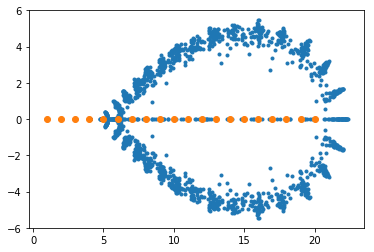

(4.8109203617564926, 3.32043944337924e+18)

In [3]:
prob2()

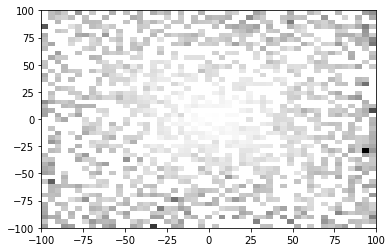

In [4]:
prob4()

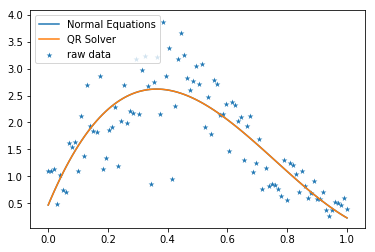

(5.142219015753495, 5.142219015753495)

In [5]:
prob5(3)

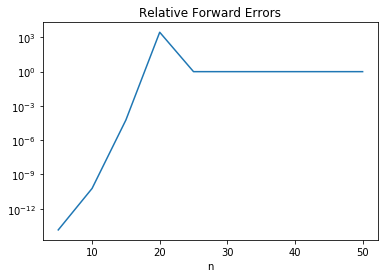

In [6]:
prob6()